# Evaluate
This notebook imports the embeddings of the specified dataset created with the specified model and computes the evaluation scores as specified in the report.

In [1]:
import pandas as pd
import sys
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

### Import Data

In [2]:
dataset_name = 'mozilla_firefox'
model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
dataset_filename = '../data/' + dataset_name+'.pkl'
embeddings_filename = '../data/' + dataset_name + '_embeddings_' + model_name + '.pkl'

#### Dataset

In [3]:
df = pd.read_pickle(dataset_filename)
df['Content'] = df['Title'] + ' ' + df['Description']
df["Issue_id"] = df["Issue_id"].astype('Int64')

#### Embeddings

In [4]:

embeddings_df = pd.read_pickle(embeddings_filename)
embeddings_df

,Embedding,Issue_id,Duplicated_issues
0,"[0.012851419, -0.33054876, -0.006574377, -0.07...",335190,"[335186, 334862]"
1,"[0.03474505, -0.56811595, 0.050481685, -0.0072...",213375,"[205129, 215031]"
2,"[0.11539562, -0.9503943, -0.005325891, -0.0740...",364824,"[514796, 364797]"
3,"[-0.20026457, -0.37414235, -0.072336145, -0.23...",294616,"[236336, 227922, 454518]"
4,"[0.1587349, -0.33249483, -0.105194755, -0.1230...",787029,"[651803, 787021, 787022]"
...,...,...,...
122,"[0.016738348, -0.34629786, 0.037005637, -0.330...",248180,"[227241, 172962]"
123,"[-0.20274988, -0.5376741, -0.02285491, 0.06090...",614817,[587440]
124,"[0.12489801, -0.36991528, 0.040070787, -0.3813...",266748,[260188]
125,"[0.039607365, 0.26415166, -0.11275197, 0.17315...",282475,[219846]


#### Add Duplicated_issue and Duplicated_issues Columns to Embeddings Dataframe

In [5]:
embeddings_df = pd.merge(embeddings_df, df[['Issue_id', 'Duplicated_issues']], on='Issue_id', how='left')

### Import Sampled Data (This needs to be ran seperately)

In [10]:
dataset_name = 'mozilla_firefox'
model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
dataset_filename = '../data/' + dataset_name+ '_subset.pkl'
embeddings_filename = '../data/' + dataset_name + '_embeddings_' + model_name + '.pkl'

This already has the duplicated issues and issue id (added in Embeddings notebook)

In [11]:
embeddings_df = pd.read_pickle(embeddings_filename)
embeddings_df.head()



,Embedding,Issue_id,Duplicated_issues
0,"[0.012851419, -0.33054876, -0.006574377, -0.07...",335190,"[335186, 334862]"
1,"[0.03474505, -0.56811595, 0.050481685, -0.0072...",213375,"[205129, 215031]"
2,"[0.11539562, -0.9503943, -0.005325891, -0.0740...",364824,"[514796, 364797]"
3,"[-0.20026457, -0.37414235, -0.072336145, -0.23...",294616,"[236336, 227922, 454518]"
4,"[0.1587349, -0.33249483, -0.105194755, -0.1230...",787029,"[651803, 787021, 787022]"


### Evaluate

In [27]:
def compute_f1(embeddings_df, threshold=0.5):
    similarity_matrix = cosine_similarity(embeddings_df['Embedding'].tolist())
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for i in range(len(embeddings_df)):
        for j in range(i + 1, len(embeddings_df)):
            # Handling noise in data: the content is exact the same (causing the score to be above of thershold) but ids are different and they are not part of eachothers duplicated issues 
            # please check embedding's data inconsistencies section
            if similarity_matrix[i, j] > 0.98:
                continue
            is_duplicate = False

            # Check if i's issue_id is in j's duplicated list or if j's issue_id is in i's duplicated list
            is_duplicate = (embeddings_df['Issue_id'].iloc[j] in embeddings_df['Duplicated_issues'].iloc[i]) or (embeddings_df['Issue_id'].iloc[i] in embeddings_df['Duplicated_issues'].iloc[j])

            is_above_threshold = similarity_matrix[i, j] >= threshold
            if is_duplicate and is_above_threshold:
                true_positives += 1
            elif is_duplicate and not is_above_threshold:
                false_negatives += 1
            elif not is_duplicate and is_above_threshold:
                false_positives += 1
            elif not is_duplicate and not is_above_threshold:
                true_negatives += 1

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1, precision, recall, similarity_matrix, true_positives, false_positives, false_negatives, true_negatives

In [28]:
f1, precision, recall, similarity_matrix, true_positives, false_positives, false_negatives, true_negatives = compute_f1(embeddings_df, threshold=0.622)


# actually duplicates, flagged duplicate 
print('True positives: ', true_positives)

# actually duplicates and not flagged
print('false negative: ', false_negatives)

# not duplicates and not flagged
print('true negative: ', true_negatives)

# not duplicates and flagged
print('false postive: ', false_positives)


print('F1 score:', f1)
print('Precision:', precision)
print('Recall', recall)

True positives:  40
false negative:  28
true negative:  7863
false postive:  45
F1 score: 0.5228758169934641
Precision: 0.47058823529411764
Recall 0.5882352941176471


### Evaluating using cross entropy loss

-  Since the output of cosine similarity is a continuous value between -1 and 1, and we are interested in a binary classification problem (with true labels being 0 or 1) we are transforming the cosine similarity scores to a [0, 1] range to represent probabilities. 

A common approach is to use the sigmoid function to map the cosine similarities to probabilities. 

In [29]:
import torch.nn.functional as F

def compute_crossEntropy(embeddings_df):
    similarity_matrix = cosine_similarity(embeddings_df['Embedding'].tolist())

    # Prepare lists to store similarity scores and the ground truth labels
    similarity_scores = []
    ground_truth_labels = []

    for i in range(len(embeddings_df)):
        for j in range(i + 1, len(embeddings_df)):
            is_duplicate = False
            # Handling noise in data: the content is exact the same (causing the score to be above of thershold) but ids are different and they are not part of eachothers duplicated issues 
            # please check embedding's data inconsistencies section
            if similarity_matrix[i, j] > 0.98:
                continue
            # Check if i's issue_id is in j's duplicated list or if j's issue_id is in i's duplicated list
            is_duplicate = (embeddings_df['Issue_id'].iloc[j] in embeddings_df['Duplicated_issues'].iloc[i]) or (embeddings_df['Issue_id'].iloc[i] in embeddings_df['Duplicated_issues'].iloc[j])
            ground_truth = 1 if is_duplicate else 0
            
            # Store the similarity score and the ground truth
            similarity_scores.append(similarity_matrix[i, j])
            ground_truth_labels.append(ground_truth)
                        

    similarity_scores_tensor = torch.tensor(similarity_scores)
    ground_truth_labels_tensor = torch.tensor(ground_truth_labels, dtype=torch.float)

    # Apply sigmoid to interpret similarity scores as probabilities
    probabilities = torch.sigmoid(similarity_scores_tensor)
    # Compute binary cross-entropy loss
    loss = F.binary_cross_entropy(probabilities, ground_truth_labels_tensor)
    return loss

In [30]:
loss = compute_crossEntropy(embeddings_df)
print("cross entropy loss is: ", loss)


cross entropy loss is:  tensor(0.8845)


### ROC-AUC Evaluation

In [19]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_roc_auc(embeddings_df):
    # Assuming cosine_similarity is a function that computes the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_df['Embedding'].tolist())
    ground_truth = []
    scores = []

    for i in range(len(embeddings_df)):
        for j in range(i + 1, len(embeddings_df)):
            is_duplicate = (embeddings_df['Issue_id'].iloc[j] in embeddings_df['Duplicated_issues'].iloc[i]) or \
                           (embeddings_df['Issue_id'].iloc[i] in embeddings_df['Duplicated_issues'].iloc[j])
            ground_truth.append(int(is_duplicate))
            scores.append(similarity_matrix[i, j])

    # Convert to numpy arrays for sklearn
    ground_truth = np.array(ground_truth)
    scores = np.array(scores)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(ground_truth, scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc




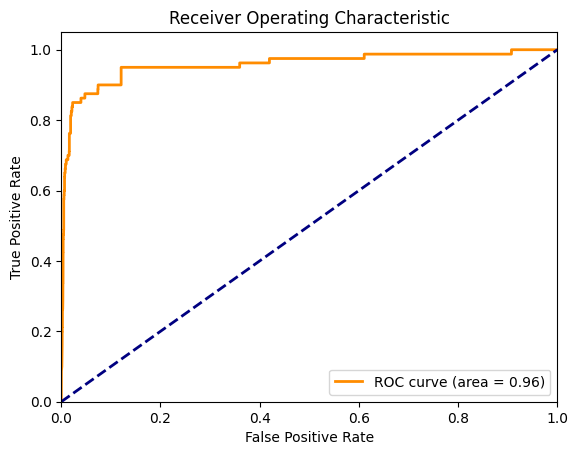

ROC-AUC: 0.9570201047847494


In [20]:
# Call the function
roc_auc = compute_roc_auc(embeddings_df)
print(f"ROC-AUC: {roc_auc}")